# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        
        self.y0 = y.mean()
        self.y_new = self.y0
        self.gammas = []
        for i in range(self.n_estimators):
            pred, tree = self._fit_predict_tree(x, y-self.y_new)[0], self._fit_predict_tree(x, y-self.y_new)[1]
            gamma = self.gamma(x, y, b=pred)
            self.y_new += gamma * self.learning_rate * pred
            self.gammas.append(gamma)
            self.trees.append(tree)
        
        
    def gamma(self, x, y, b):
        gamma = 1
        self.gammas.append(gamma)
        if len(self.trees) >= 1:    
            gamma = minimize(lambda gamma: np.linalg.norm(y - self.y_new - gamma * b)**2, x0=self.gammas[-1]).x[0]
            self.gammas.append(gamma)
        return self.gammas[-1]
    
    
    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        return tree.predict(x), tree
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        y_pred = self.y0
        for i, tree in enumerate(self.trees):
            y_pred += self.gammas[i] * self.learning_rate * tree.predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fun

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [101]:
np.random.seed(19052019)
gb = GradientBoosting(n_estimators=850, max_depth=7, learning_rate=0.081)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [102]:
mean_squared_error(y_test, y_pred)

10.117826440295467

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / Нет

Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [81]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [82]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [83]:
%%time
# Референс
from catboost import CatBoostClassifier
#from sklearn.model_selection import GridSearchCV - будем использовать grid_search из catboost'a

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

model = CatBoostClassifier(
    iterations=2000,
    random_seed=43,
    loss_function='Logloss',
    verbose=False
)

grid = {'learning_rate': [0.001, 0.01, 0.1],
        'depth': range(1, 7),
        'l2_leaf_reg': [1, 2, 3, 4, 5]
       }

grid_search_result = model.grid_search(grid,
                                       X=X_train_part,
                                       y=y_train_part,
                                       plot=False,
                                       verbose=False,
                                       calc_cv_statistics=False)


bestTest = 0.4573651919
bestIteration = 1999


bestTest = 0.4438586262
bestIteration = 1986


bestTest = 0.4425118358
bestIteration = 1999


bestTest = 0.457393374
bestIteration = 1999


bestTest = 0.4438422278
bestIteration = 1999


bestTest = 0.4425721884
bestIteration = 1998


bestTest = 0.4573874624
bestIteration = 1999


bestTest = 0.4439132273
bestIteration = 1999


bestTest = 0.4425278563
bestIteration = 1999


bestTest = 0.4573625947
bestIteration = 1999


bestTest = 0.4438935739
bestIteration = 1994


bestTest = 0.4425347172
bestIteration = 1996


bestTest = 0.4573729923
bestIteration = 1999


bestTest = 0.4438993926
bestIteration = 1997


bestTest = 0.442694156
bestIteration = 1996


bestTest = 0.453326813
bestIteration = 1999


bestTest = 0.4408627499
bestIteration = 1999


bestTest = 0.4386160944
bestIteration = 1574


bestTest = 0.4533514054
bestIteration = 1999


bestTest = 0.4409029606
bestIteration = 1999


bestTest = 0.4385260998
bestIteration = 1628


bestTest = 0.45

In [84]:
opt_depth = grid_search_result['params']['depth']
opt_l2 = grid_search_result['params']['l2_leaf_reg']
opt_lr = grid_search_result['params']['learning_rate']
print(opt_depth, opt_l2, opt_lr)

6 3 0.1


In [85]:
%%time
model = CatBoostClassifier(
    iterations=2000,
    random_seed=43,
    loss_function='Logloss',
    depth=opt_depth,
    l2_leaf_reg = opt_l2,
    learning_rate = opt_lr
)
model.fit(
    X_train, y_train,
    use_best_model=False,
    verbose=False,
    plot=False)
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

CPU times: total: 1min 38s
Wall time: 21.4 s


0.7662236550701387

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [86]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance
from numba import njit

In [142]:
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        
    
    def fit_predict(self, X):
        self.X = X
        self.visited = []
        self.clusters = []
        self.neighbors = {}
        
        for i in range(X.shape[0]):
            if i in self.visited:
                continue                            # Если точка уже встречалась, то пропускаем ее
            self.neighbors[i] = self.range_query(i)
            if len(self.neighbors[i]) >= self.min_samples:
                self.visited.append(i)
                new_cluster = self.grow_cluster(i, self.neighbors[i])
                self.clusters.append(new_cluster)
                
        # Раздаем кластерам собственные числа-метки
        labels = np.empty(self.X.shape[0], dtype=int)
        labels[:] = len(self.clusters)
        for cluster_num, cluster in enumerate(self.clusters):
            for point in cluster:
                labels[point] = cluster_num
                
        labels = np.where(labels < np.max(labels), labels, -1)    # Просто чтобы были такие же цвета, как в склерне
        return labels
    
    def grow_cluster(self, root, neighbours):
        
        cluster = [root]
        for neighbour in neighbours:
            if neighbour in self.visited:
                cluster.append(neighbour)
            else:
                cluster.append(neighbour)
                self.visited.append(neighbour)
                self.neighbors[neighbour] = self.range_query(neighbour)
                if len(self.neighbors[neighbour]) >= self.min_samples:
                    grown_cluster = self.grow_cluster(neighbour, self.neighbors[neighbour])
                    cluster += grown_cluster
                    
        return cluster
        
    
    def range_query(self, x):
        neighbours = []
        for i in range(self.X.shape[0]):
            if self.dist(self.X[i], self.X[x]) < self.eps:
                neighbours.append(i)
        return neighbours

    @staticmethod
    @njit
    def dist(a, b):
        return np.sqrt(np.sum((a-b)**2))

Проверим себя на простом примере:

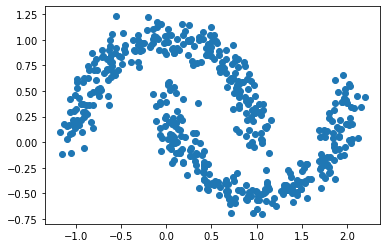

In [143]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

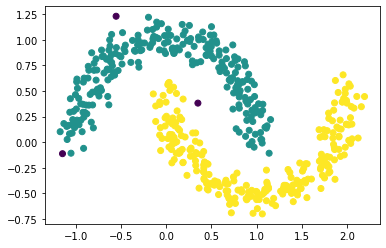

In [144]:
# your code here
db = dbscan(eps=0.2, min_samples=15)
clusters = db.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

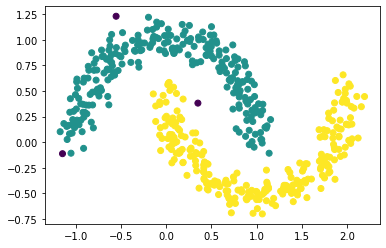

In [145]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=15).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



In [146]:
url = 'https://w7.pngwing.com/pngs/684/352/png-transparent-one-punch-man-saitama-anime-superhero-one-punch-child-face-hand.png'
headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'uk,en-US;q=0.9,en;q=0.8,ru;q=0.7',
    'sec-ch-ua': '"Google Chrome";v="89", "Chromium";v="89", ";Not A Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'none',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36'
}

как считать изображение точками я взял $\href{https://stackoverflow.com/questions/43443337/image-of-function-extracting-points-with-python}{отсюда}$

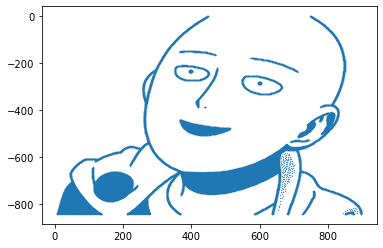

In [147]:
import cv2
import numpy as np
from urllib.request import Request, urlopen
import matplotlib.pyplot as plt
req = urlopen(Request(url, headers=headers))
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1)
ret, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
scatter = np.where(image==0)
x, y = scatter[1],-scatter[0]
plt.scatter(x, y, marker='.', s=0.1)  
plt.show()

In [148]:
sitama = np.stack((x, y), axis=-1)

In [149]:
clusters = DBSCAN(eps=15, min_samples=50).fit_predict(sitama)

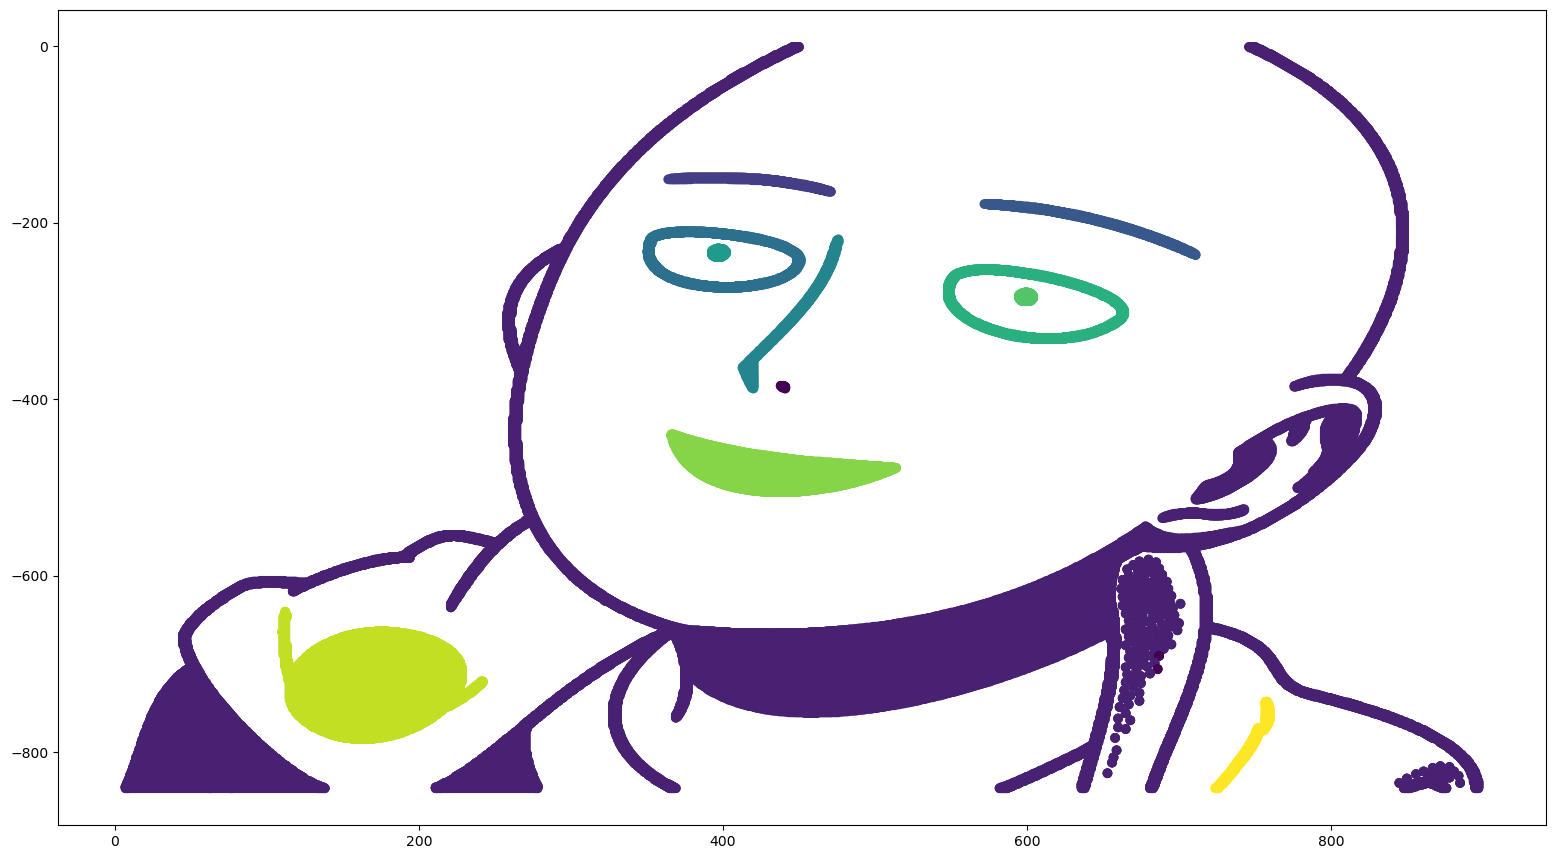

In [150]:
plt.figure(figsize=(19.20, 10.80), dpi=100)
plt.scatter(x, y, c=clusters)
None


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [151]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: total: 0 ns
Wall time: 4 ms


In [152]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: total: 250 ms
Wall time: 243 ms


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

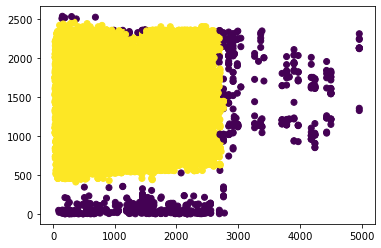

array([-1,  0], dtype=int64)

In [98]:
# your code here  ლ(ಠ益ಠლ)
data_ = train[['Distance', 'DepTime']]
clusters = DBSCAN(eps=100, min_samples=65).fit_predict(data_)
plt.scatter(data_['Distance'], data_['DepTime'], c=clusters)
plt.show()
np.unique(clusters)

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ чем меньше $\varepsilon$ и больше min_samples, тем больше шума, так как не хватает точек для создания кластера.

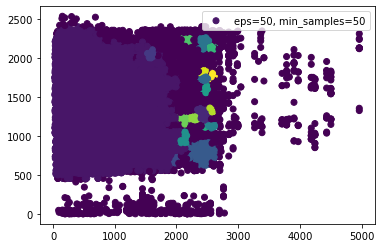

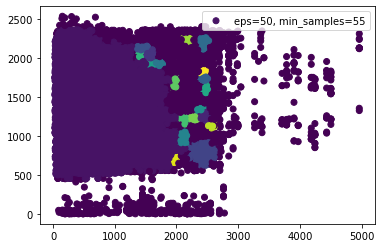

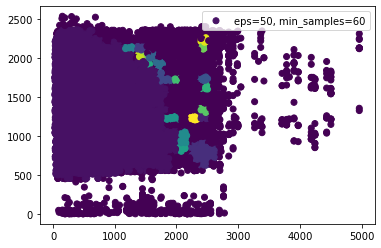

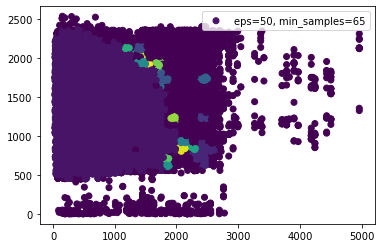

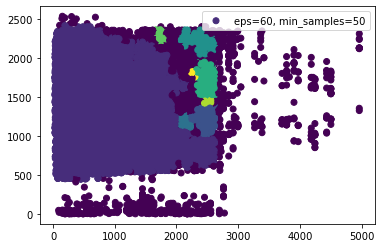

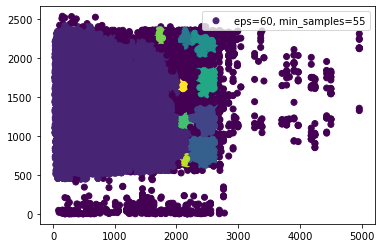

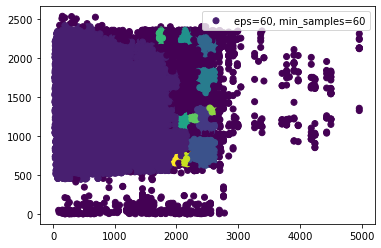

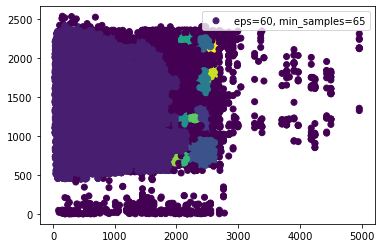

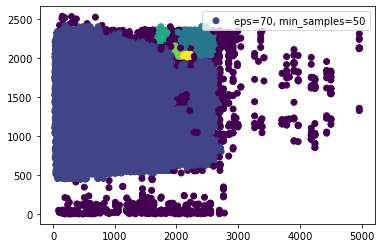

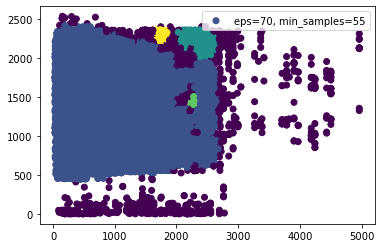

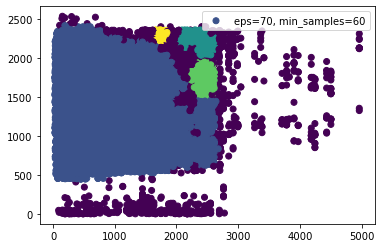

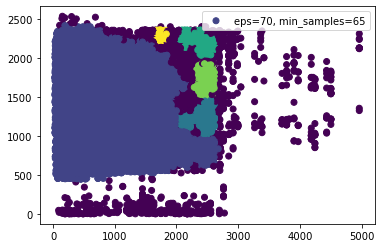

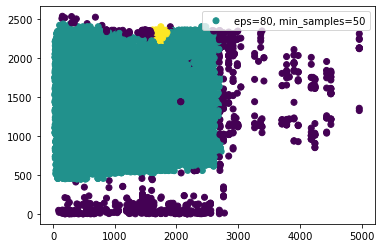

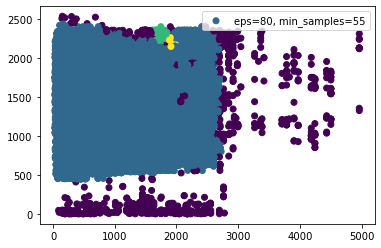

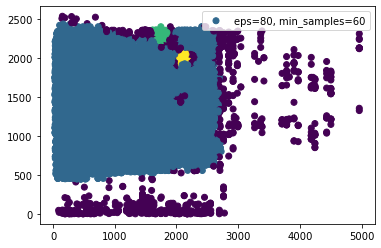

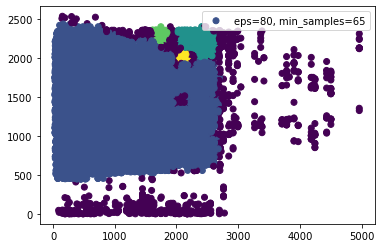

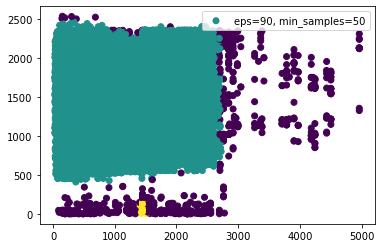

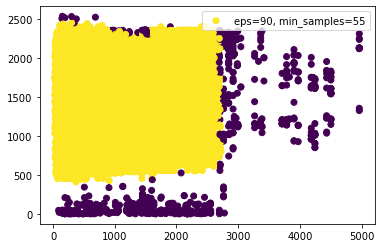

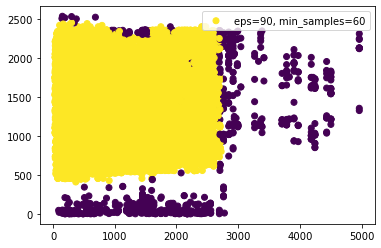

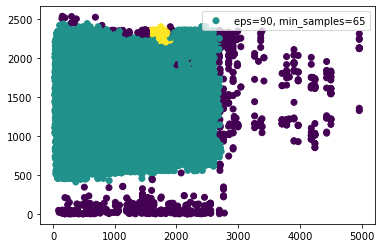

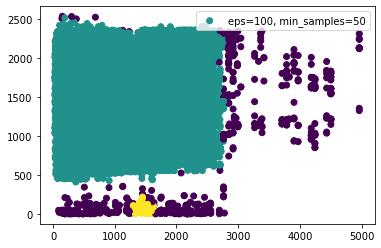

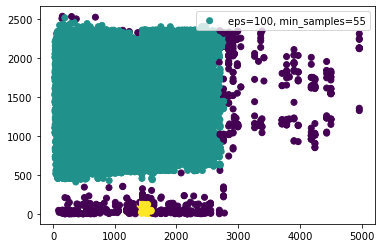

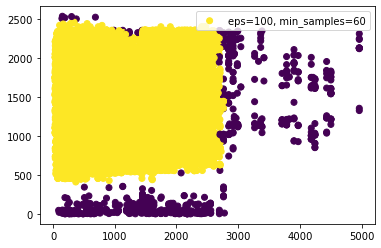

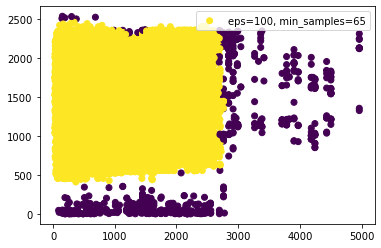

In [99]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆
eps = [10*x for x in range(5, 11)]
min_samples = [x for x in range(50, 70, 5)]
for i in range(len(eps)):
    for j in range(len(min_samples)):
        clusters = DBSCAN(eps=eps[i], min_samples=min_samples[j]).fit_predict(data_)
        plt.scatter(data_['Distance'], data_['DepTime'], c=clusters, label=f'eps={eps[i]}, min_samples={min_samples[j]}')
        plt.legend()
        plt.show()

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [100]:
# your code here  ¯\_(ツ)_/¯
train['cluster'] = clusters
test['cluster'] = clusters
X_train = train[['Distance', 'DepTime', 'cluster']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime', 'cluster']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [101]:
%%time
model = CatBoostClassifier(
    iterations=2000,
    random_seed=43,
    loss_function='Logloss',
    depth=opt_depth,
    l2_leaf_reg = opt_l2,
    learning_rate = opt_lr
)
model.fit(
    X_train, y_train,
    use_best_model=False,
    verbose=False,
    plot=False)
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

CPU times: total: 1min 39s
Wall time: 22.4 s


0.7717880846844435

__Ответ:__
Появился дополнительный признак, который упрощает разбиение

# Небольшие подарочки

раз cv2 импортнут, то через imshow буду фотки вставлять, чота лень по-другому:)

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

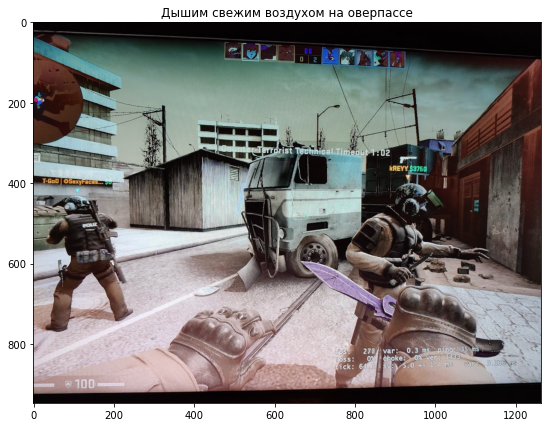

In [102]:
plt.figure(figsize=(15, 7))
plt.imshow(cv2.imread('over.jpg'))
plt.title('Дышим свежим воздухом на оверпассе')
None

**+0.1 балла** за смешной мем по машинному обучению

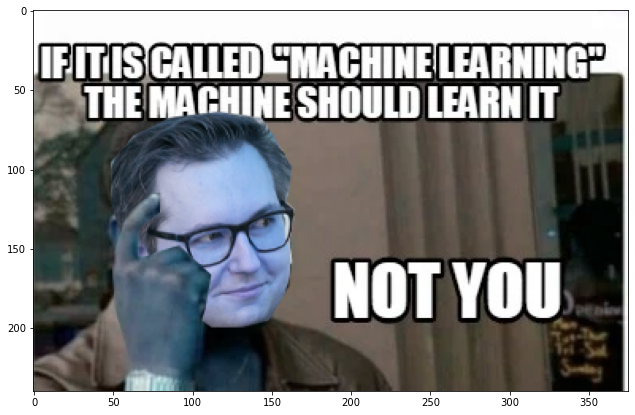

In [103]:
plt.figure(figsize=(15, 7))
plt.imshow(cv2.imread('mem_f.png'))
None

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

Впечатления положительные, ничего плохого выделить не могу, только отметить классного лектора, классного семинариста и классных ассистов, которым большое спасибо за супер удобную табличку, которая считает все накопы и тп. Особо каких-то сложностей не было, потому что у меня на параллельном предмете почти все те же самые алгоритмы реализовывались. Из тем мне больше всего зашли деревья (random forest и бустинг) и дбскан, так как с ним картинки прикольные получаются